# data preprocessing

In [4]:
from sklearn.datasets import make_circles


In [6]:
n_samples = 2000
X,y = make_circles(n_samples, noise=0.03, random_state=42)

In [7]:
X[:10] ,  y[:10]

(array([[ 0.47109875, -0.58158579],
        [-0.61696058,  0.80818956],
        [-0.3999557 ,  0.70796779],
        [ 0.82938523, -0.60057314],
        [-0.16419138,  0.76128858],
        [-0.16190608,  0.77881744],
        [ 0.9701    , -0.35427244],
        [-0.10573729, -0.80478381],
        [ 0.90810557,  0.45945033],
        [-0.34274852,  0.73021408]]),
 array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1]))

In [8]:
import pandas as pd

In [10]:
df = pd.DataFrame({
    "x1" : X[:,0],
    "x2" : X[:,1],
    "y" : y
})

df.head()

,x1,x2,y
0,0.471099,-0.581586,1
1,-0.616961,0.808190,0
2,-0.399956,0.707968,1
3,0.829385,-0.600573,0
4,-0.164191,0.761289,1


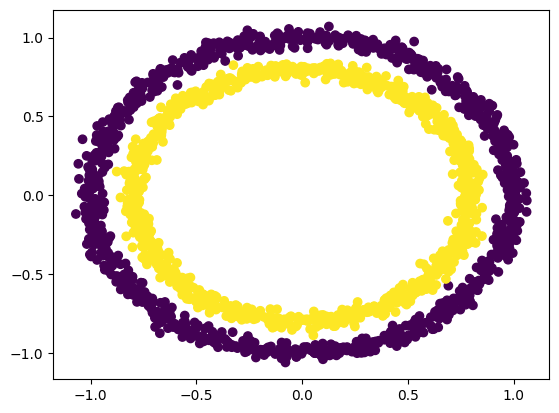

In [12]:
import matplotlib.pyplot as plt
plt.scatter(df.x1, df.x2, c=df.y)

In [13]:
X.shape , y.shape

((2000, 2), (2000,))

In [27]:
import torch
# Convert to torch tensors if not already
if not isinstance(X, torch.Tensor):
    X = torch.from_numpy(X).type(torch.float)
if not isinstance(y, torch.Tensor):
    y = torch.from_numpy(y).type(torch.float)

X[:10] , y[:10]

(tensor([[ 0.4711, -0.5816],
         [-0.6170,  0.8082],
         [-0.4000,  0.7080],
         [ 0.8294, -0.6006],
         [-0.1642,  0.7613],
         [-0.1619,  0.7788],
         [ 0.9701, -0.3543],
         [-0.1057, -0.8048],
         [ 0.9081,  0.4595],
         [-0.3427,  0.7302]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 1., 0., 1.]))

In [18]:
from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

len(X_train) , len(X_test) , len(y_train) , len(y_test)

(1600, 400, 1600, 400)

# make model

In [23]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [41]:
class CircleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = torch.nn.Linear(in_features=2, out_features=16)
        self.layer_2 = torch.nn.Linear(in_features=16, out_features=8)
        self.layer_3 = torch.nn.Linear(in_features=8, out_features=1)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [42]:
model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [44]:
untrained_pred = model(X_test.to(device))
untrained_pred[:10]

tensor([[ 0.0566],
        [ 0.0487],
        [ 0.0705],
        [-0.0195],
        [-0.0685],
        [-0.0111],
        [ 0.0233],
        [-0.0273],
        [-0.0386],
        [ 0.0419]], grad_fn=<SliceBackward0>)

In [47]:
torch.sigmoid(untrained_pred[:10].squeeze())  , y_test[:10]

(tensor([0.5142, 0.5122, 0.5176, 0.4951, 0.4829, 0.4972, 0.5058, 0.4932, 0.4904,
         0.5105], grad_fn=<SigmoidBackward0>),
 tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 1.]))

In [49]:
torch.round(torch.sigmoid(untrained_pred[:10].squeeze()))

tensor([1., 1., 1., 0., 0., 0., 1., 0., 0., 1.], grad_fn=<RoundBackward0>)

In [51]:
from sklearn.metrics import accuracy_score

In [54]:
acc = accuracy_score(y_test.detach().numpy(), torch.round(torch.sigmoid(untrained_pred.squeeze())).detach().numpy())
acc

0.505

In [55]:
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [64]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

#training loop

torch.manual_seed(42)

epochs = 10000
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)
for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))


    train_accuracy = accuracy_fn(y_train, y_pred)
    loss_train = loss(y_logits, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    model.eval()


    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        loss_test = loss(test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, test_pred)
    if epoch % 10 == 0:
        print(f'Epoch : {epoch} , Train_loss : {loss_train:.4f} , Train_acc : {train_accuracy:.2f} //// Test_loss : {loss_test:.4f} , test_acc : {test_accuracy:.2f}')

Epoch : 0 , Train_loss : 0.0018 , Train_acc : 100.00 //// Test_loss : 0.0054 , test_acc : 99.75
Epoch : 10 , Train_loss : 0.0018 , Train_acc : 100.00 //// Test_loss : 0.0054 , test_acc : 99.75
Epoch : 20 , Train_loss : 0.0018 , Train_acc : 100.00 //// Test_loss : 0.0054 , test_acc : 99.75
Epoch : 30 , Train_loss : 0.0018 , Train_acc : 100.00 //// Test_loss : 0.0054 , test_acc : 99.75
Epoch : 40 , Train_loss : 0.0018 , Train_acc : 100.00 //// Test_loss : 0.0054 , test_acc : 99.75
Epoch : 50 , Train_loss : 0.0018 , Train_acc : 100.00 //// Test_loss : 0.0054 , test_acc : 99.75
Epoch : 60 , Train_loss : 0.0018 , Train_acc : 100.00 //// Test_loss : 0.0053 , test_acc : 99.75
Epoch : 70 , Train_loss : 0.0018 , Train_acc : 100.00 //// Test_loss : 0.0053 , test_acc : 99.75
Epoch : 80 , Train_loss : 0.0018 , Train_acc : 100.00 //// Test_loss : 0.0053 , test_acc : 99.75
Epoch : 90 , Train_loss : 0.0018 , Train_acc : 100.00 //// Test_loss : 0.0053 , test_acc : 99.75
Epoch : 100 , Train_loss : 0.00

In [68]:
# eval

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


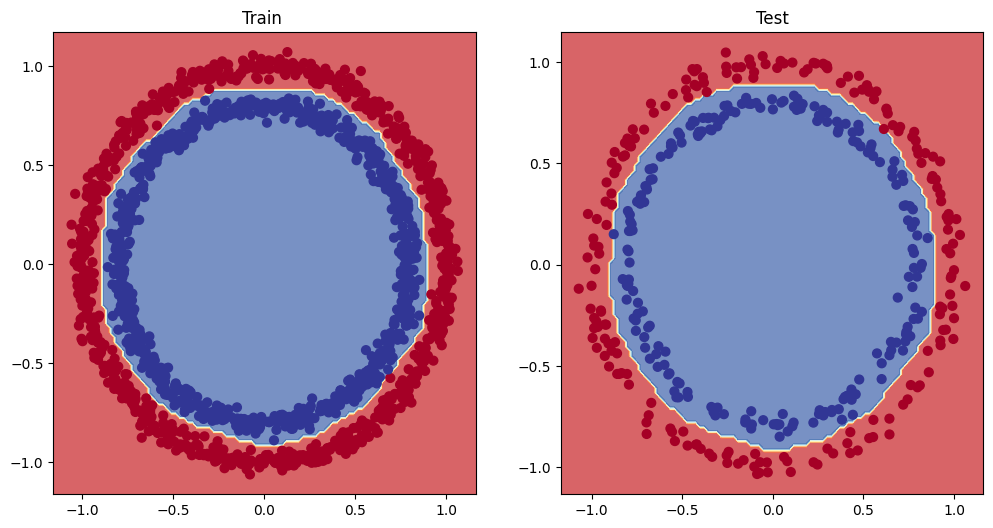

In [67]:
plt.figure(figsize=(12 , 6))
plt.subplot(1 , 2 , 1)
plt.title("Train ")
plot_decision_boundary(model , X_train, y_train)
plt.subplot(1 , 2 , 2)
plt.title("Test")
plot_decision_boundary(model , X_test, y_test)